# Logistic Regression for Sentiment Analysis

Adapted from http://nbviewer.jupyter.org/github/rasbt/pattern_classification/blob/master/machine_learning/scikit-learn/outofcore_modelpersistence.ipynb

<br>
<br>

## The IMDb Movie Review Dataset

In this section, we will train a simple logistic regression model to classify movie reviews from the 50k IMDb review dataset that has been collected by Maas et. al.

> AL Maas, RE Daly, PT Pham, D Huang, AY Ng, and C Potts. Learning word vectors for sentiment analysis. In Proceedings of the 49th Annual Meeting of the Association for Computational Lin- guistics: Human Language Technologies, pages 142–150, Portland, Oregon, USA, June 2011. Association for Computational Linguistics

[Source: http://ai.stanford.edu/~amaas/data/sentiment/]

The dataset consists of 50,000 movie reviews from the original "train" and "test" subdirectories. The class labels are binary (1=positive and 0=negative) and contain 25,000 positive and 25,000 negative movie reviews, respectively.
For simplicity, I assembled the reviews in a single CSV file.


In [1]:
import pandas as pd
# if you want to download the original file:
df = pd.read_csv('https://raw.githubusercontent.com/rasbt/pattern_classification/master/data/50k_imdb_movie_reviews.csv')
# otherwise load local file
df[['review', 'sentiment']].to_csv('shuffled_movie_data.csv', index=False)
df = pd.read_csv('shuffled_movie_data.csv')
df.tail()

,review,sentiment
49995,"Towards the end of the movie, I felt it was to...",0
49996,This is the kind of movie that my enemies cont...,0
49997,I saw 'Descent' last night at the Stockholm Fi...,0
49998,Some films that you pick up for a pound turn o...,0
49999,"This is one of the dumbest films, I've ever se...",0


Let us shuffle the class labels.

In [2]:
import numpy as np
## uncomment these lines if you have dowloaded the original file:
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df[['review', 'sentiment']].to_csv('shuffled_movie_data.csv', index=False)
df.head()

,review,sentiment
11841,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
19602,OK... so... I really like Kris Kristofferson a...,0
45519,"***SPOILER*** Do not read this, if you think a...",0
25747,hi for all the people who have seen this wonde...,1
42642,"I recently bought the DVD, forgetting just how...",0


<br>
<br>

# Preprocessing Text Data



## Tokenizació**n** y conversión a Secuencias de cada Review

In [3]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=2000, split=' ')

data = pd.read_csv('shuffled_movie_data.csv')
tokenizer.fit_on_texts(data['review'])
X = tokenizer.texts_to_sequences(data['review'])

Using TensorFlow backend.


## Adheriendo padding a cada review tokenizado

In [0]:
from keras.preprocessing.sequence import pad_sequences

X = pad_sequences(X)
Y = data['sentiment']

## Separando los datos de Entrenamiento y Testing

In [5]:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation  import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
print('X_train.shape: ', X_train.shape)
print('Y_train.shape: ', Y_train.shape)
print('X_test.shape: ', X_test.shape)
print('Y_test.shape: ', Y_test.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


X_train.shape:  (40000, 1939)
Y_train.shape:  (40000,)
X_test.shape:  (10000, 1939)
Y_test.shape:  (10000,)


# Learning (Keras)

## Creación del Modelo

In [0]:
# !pip install keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout

model = Sequential()

## Capa de Embedding

In [7]:
model.add( Embedding(2000, 32, input_length = X.shape[1], dropout=0.2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  """Entry point for launching an IPython kernel.


## Primera Capa LSTM Bidireccional

In [0]:
model.add(Dropout(0.2))
model.add( Bidirectional( LSTM(20, return_sequences=True)))

## Segunda Capa LSTM Bidireccional

In [0]:
model.add(Dropout(0.2))
model.add( Bidirectional( LSTM(20)))

## Capa Final de Salida

In [0]:
model.add(Dropout(0.2))
model.add( Dense(1, activation = 'sigmoid'))

## Compilación y Resumen del Modelo

In [11]:
model.compile(loss = 'binary_crossentropy', optimizer = 'RMSprop', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1939, 32)          64000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1939, 32)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1939, 40)          8480      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1939, 40)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40)                9760      
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total para

<br>
<br>

# Entrenamiento:

In [12]:
hist = model.fit(X_train, Y_train, epochs = 10, batch_size = 512, verbose = 2)

Epoch 1/3
 - 1712s - loss: 0.5141 - acc: 0.7441
Epoch 2/3
 - 1704s - loss: 0.3538 - acc: 0.8548
Epoch 3/3
 - 1700s - loss: 0.3116 - acc: 0.8720


<br>
<br>
# Predicción usando los Datos de Testing:

In [14]:
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 85.92%


# Gráficos Loss & Accuracy by Epochs

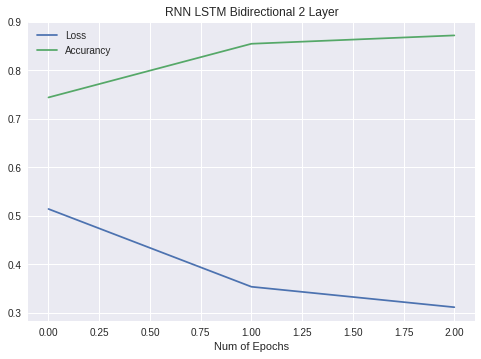

In [33]:
from pandas import DataFrame
from matplotlib import pyplot
results = DataFrame()
results['Loss'] = hist.history['loss']
results['Accuracy'] = hist.history['acc']

results.plot()
pyplot.title('RNN LSTM Bidirectional 2 Layer')
pyplot.xlabel('Num of Epochs')
pyplot.show()

<br>
<br>